In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import fitsio
from scipy.interpolate import interp1d

In [2]:
dcmass = np.hstack([fitsio.read(fname, columns=['RA', 'DEC', 'Z',
                                                'WEIGHT_CP', 'WEIGHT_NOZ',
                                                'WEIGHT_SYSTOT'])
                    for fname in ['data/galaxy_DR12v5_CMASS_North.fits.gz',
                                  'data/galaxy_DR12v5_CMASS_South.fits.gz']])
rcmass = np.hstack([fitsio.read(fname, columns=['RA', 'DEC', 'Z'])
                    for fname in ['data/random0_DR12v5_CMASS_North.fits.gz',
                                  'data/random0_DR12v5_CMASS_South.fits.gz']])

In [3]:
dqsos1 = np.hstack([fitsio.read(fname, columns=['RA', 'DEC', 'Z',
                                                'WEIGHT_CP', 'WEIGHT_NOZ',
                                                'WEIGHT_SYSTOT'])
                    for fname in ['data/eBOSS_QSO_clustering_data-NGC-vDR16.fits']])
dqsos2 = np.hstack([fitsio.read(fname, columns=['RA', 'DEC', 'Z',
                                                'WEIGHT_CP', 'WEIGHT_NOZ',
                                                'WEIGHT_SYSTOT'])
                    for fname in ['data/eBOSS_QSO_clustering_data-SGC-vDR16.fits']])
rqsos1 = np.hstack([fitsio.read(fname, columns=['RA', 'DEC', 'Z',
                                                'WEIGHT_CP', 'WEIGHT_NOZ',
                                                'WEIGHT_SYSTOT'])
                    for fname in ['data/eBOSS_QSO_clustering_random-NGC-vDR16.fits']])
rqsos2 = np.hstack([fitsio.read(fname, columns=['RA', 'DEC', 'Z',
                                                'WEIGHT_CP', 'WEIGHT_NOZ',
                                                'WEIGHT_SYSTOT'])
                    for fname in ['data/eBOSS_QSO_clustering_random-SGC-vDR16.fits']])

43787993 11099858 7169801


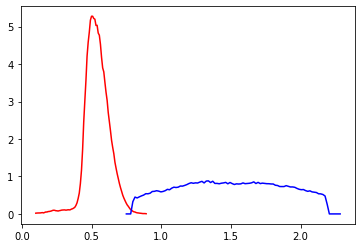

In [4]:
nzcmass, zcmass = np.histogram(dcmass['Z'], bins=100, range=[0.1, 0.9],
                               weights=dcmass['WEIGHT_SYSTOT']*(dcmass['WEIGHT_CP']+dcmass['WEIGHT_NOZ']-1),
                               density=True)
zcmass = zcmass[:-1]
nzqsos, zqsos = np.histogram(dqsos1['Z'], bins=100, range=[0.75, 2.3],
                             weights=dqsos1['WEIGHT_SYSTOT']*dqsos1['WEIGHT_CP']*dqsos1['WEIGHT_NOZ'],
                             density=True)
zqsos = zqsos[:-1]
plt.plot()
plt.plot(zcmass, nzcmass, 'r-')
plt.plot(zqsos, nzqsos, 'b-')
print(len(rcmass), len(rqsos1), len(rqsos2))

# Masks and maps

In [5]:
nside = 64
npix = hp.nside2npix(nside)

### CMASS

0.02074755972487709


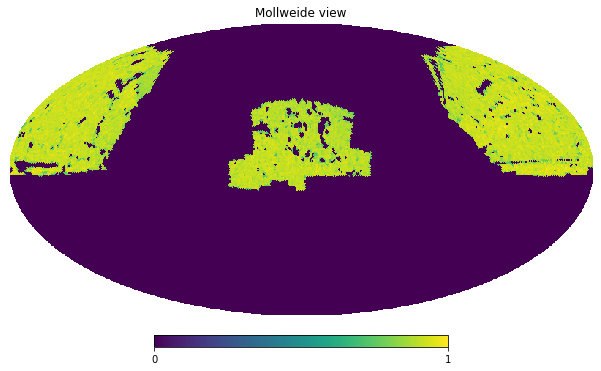

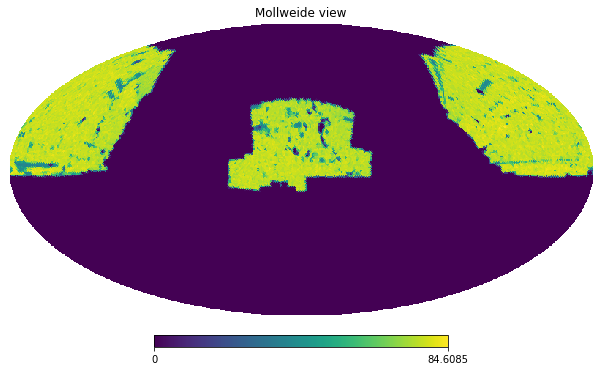

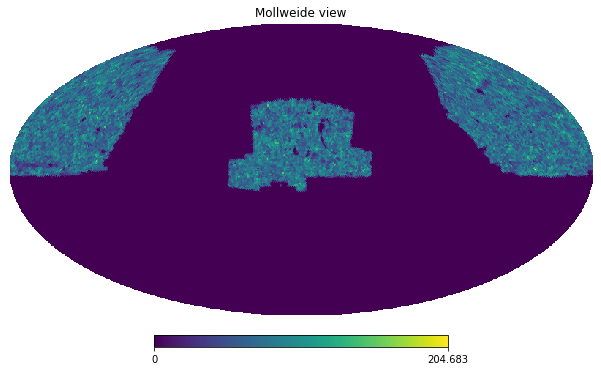

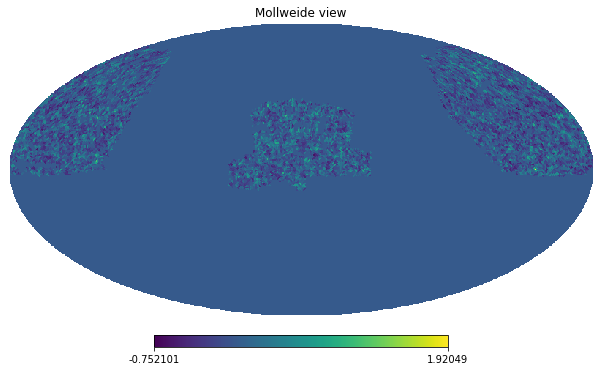

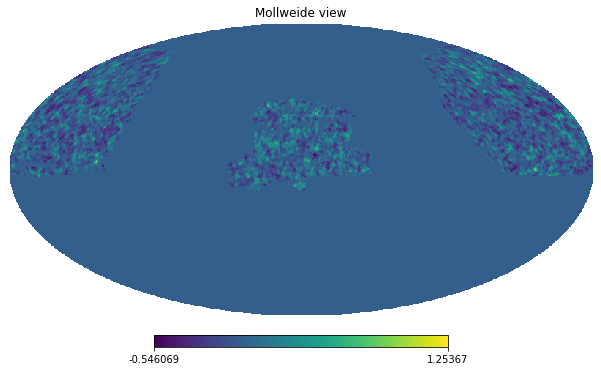

In [6]:
# Data/random counts
nran_cmass = np.bincount(hp.ang2pix(nside, rcmass['RA'], rcmass['DEC'], lonlat=True),
                         weights=np.ones(len(rcmass)), minlength=npix)
wcmass = dcmass['WEIGHT_SYSTOT']*(dcmass['WEIGHT_NOZ']+dcmass['WEIGHT_CP']-1)
ndat_cmass = np.bincount(hp.ang2pix(nside, dcmass['RA'], dcmass['DEC'], lonlat=True),
                         weights=wcmass, minlength=npix)
alpha_cmass = np.sum(wcmass)/len(rcmass)

# Delta
delta_cmass = np.zeros(npix)
goodpix = nran_cmass > 0
delta_cmass[goodpix] = (ndat_cmass[goodpix]/(alpha_cmass*nran_cmass[goodpix])-1)
# Smoothing
delta_cmass_smooth = hp.smoothing(delta_cmass, sigma=np.radians(1./2.355))
# Masking
mask_cmass = nran_cmass/np.amax(nran_cmass)
mask_cmass[mask_cmass < 0.7] = 0
delta_cmass[mask_cmass == 0] = 0
delta_cmass_smooth[mask_cmass == 0] = 0

hp.mollview(mask_cmass)
hp.mollview(nran_cmass*alpha_cmass)
hp.mollview(ndat_cmass)
hp.mollview(delta_cmass)
hp.mollview(delta_cmass_smooth)
print(alpha_cmass)

### QSOs
(we do North and South separately)

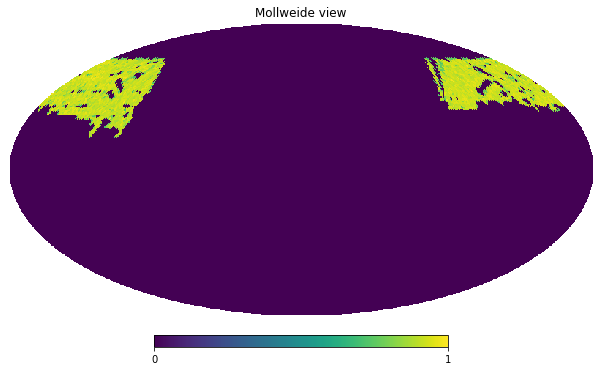

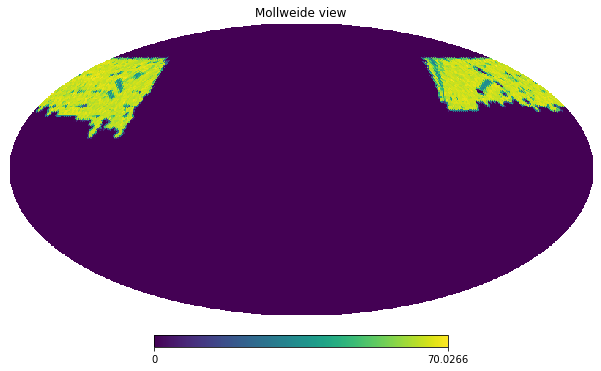

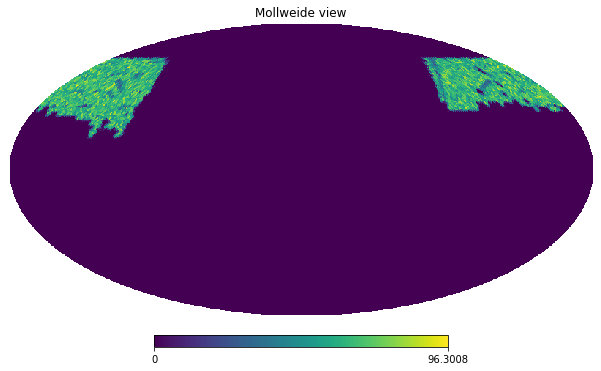

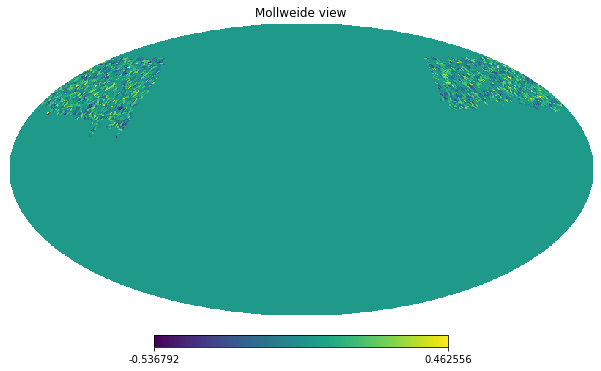

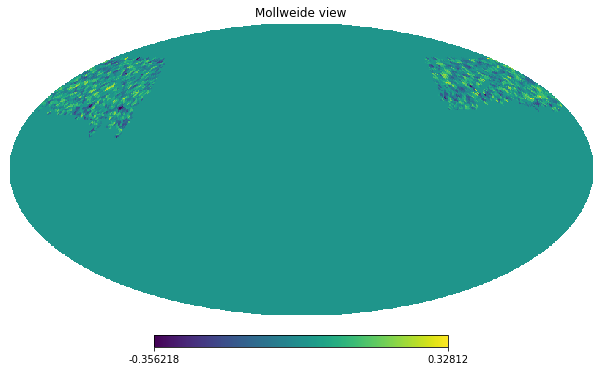

In [7]:
# Data/random counts
wrqsos = rqsos1['WEIGHT_SYSTOT']*rqsos1['WEIGHT_NOZ']*rqsos1['WEIGHT_CP']
wdqsos = dqsos1['WEIGHT_SYSTOT']*dqsos1['WEIGHT_NOZ']*dqsos1['WEIGHT_CP']
nran_qsos = np.bincount(hp.ang2pix(nside, rqsos1['RA'], rqsos1['DEC'], lonlat=True),
                        weights=wrqsos, minlength=npix)
ndat_qsos = np.bincount(hp.ang2pix(nside, dqsos1['RA'], dqsos1['DEC'], lonlat=True),
                        weights=wdqsos, minlength=npix)
alpha_qsos = np.sum(wdqsos)/np.sum(wrqsos)

# Delta
delta_qsos1 = np.zeros(npix)
goodpix = nran_qsos > 0
delta_qsos1[goodpix] = (ndat_qsos[goodpix]/(alpha_qsos*nran_qsos[goodpix])-1)
delta_qsos1[delta_qsos1 > 4] = 0
# Smoothing
delta_qsos1_smooth = hp.smoothing(delta_qsos1, sigma=np.radians(1./2.355))
# Masking
mask_qsos1 = nran_qsos/np.amax(nran_qsos)
mask_qsos1[mask_qsos1 < 0.7] = 0
delta_qsos1[mask_qsos1 == 0] = 0
delta_qsos1_smooth[mask_qsos1 == 0] = 0

hp.mollview(mask_qsos1)
hp.mollview(nran_qsos*alpha_qsos)
hp.mollview(ndat_qsos)
hp.mollview(delta_qsos1)
hp.mollview(delta_qsos1_smooth)

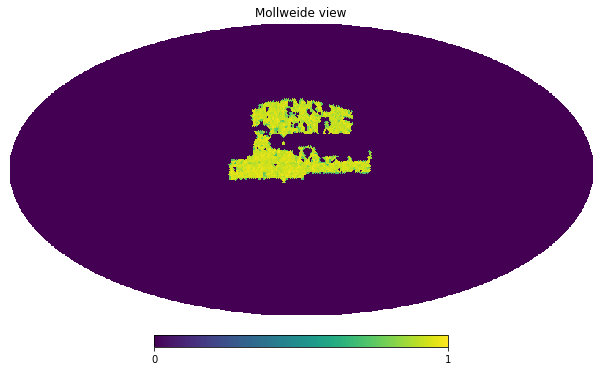

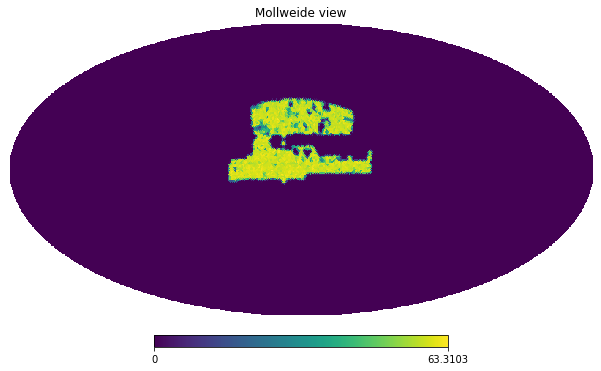

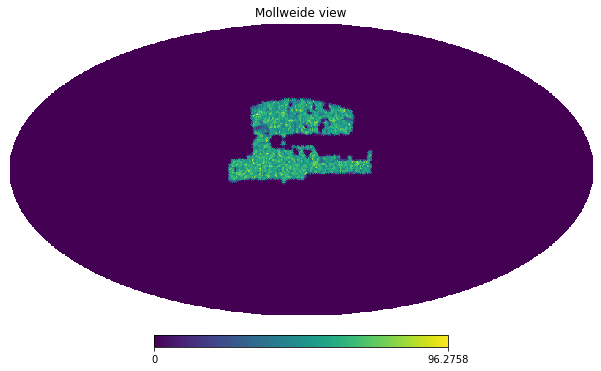

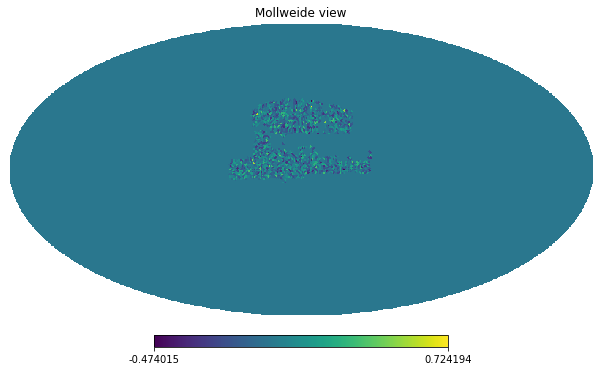

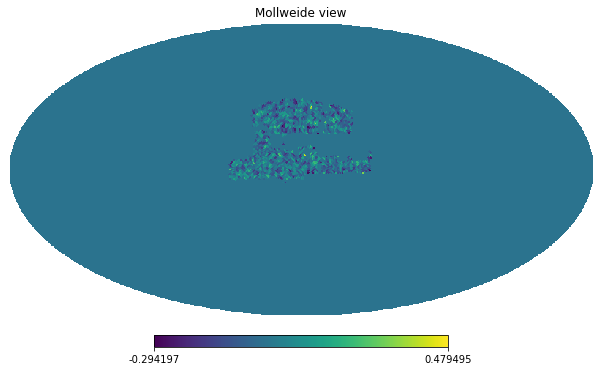

In [8]:
# Data/random counts
wrqsos = rqsos2['WEIGHT_SYSTOT']*rqsos2['WEIGHT_NOZ']*rqsos2['WEIGHT_CP']
wdqsos = dqsos2['WEIGHT_SYSTOT']*dqsos2['WEIGHT_NOZ']*dqsos2['WEIGHT_CP']
nran_qsos = np.bincount(hp.ang2pix(nside, rqsos2['RA'], rqsos2['DEC'], lonlat=True),
                        weights=wrqsos, minlength=npix)
ndat_qsos = np.bincount(hp.ang2pix(nside, dqsos2['RA'], dqsos2['DEC'], lonlat=True),
                        weights=wdqsos, minlength=npix)
alpha_qsos = np.sum(wdqsos)/np.sum(wrqsos)

# Delta
delta_qsos2 = np.zeros(npix)
goodpix = nran_qsos > 0
delta_qsos2[goodpix] = (ndat_qsos[goodpix]/(alpha_qsos*nran_qsos[goodpix])-1)
delta_qsos2[delta_qsos2 > 3] = 0
# Smoothing
delta_qsos2_smooth = hp.smoothing(delta_qsos2, sigma=np.radians(1./2.355))
# Masking
mask_qsos2 = nran_qsos/np.amax(nran_qsos)
mask_qsos2[mask_qsos2 < 0.7] = 0
delta_qsos2[mask_qsos2 == 0] = 0
delta_qsos2_smooth[mask_qsos2 == 0] = 0

hp.mollview(mask_qsos2)
hp.mollview(nran_qsos*alpha_qsos)
hp.mollview(ndat_qsos)
hp.mollview(delta_qsos2)
hp.mollview(delta_qsos2_smooth)

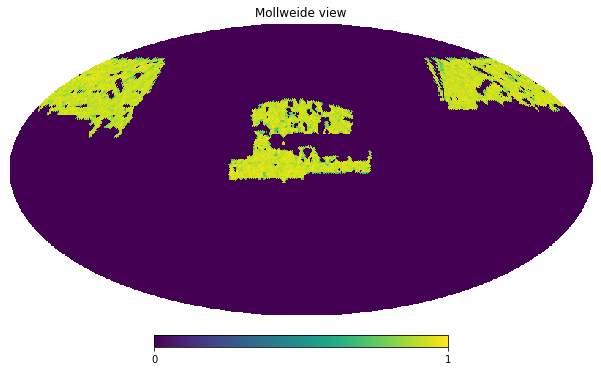

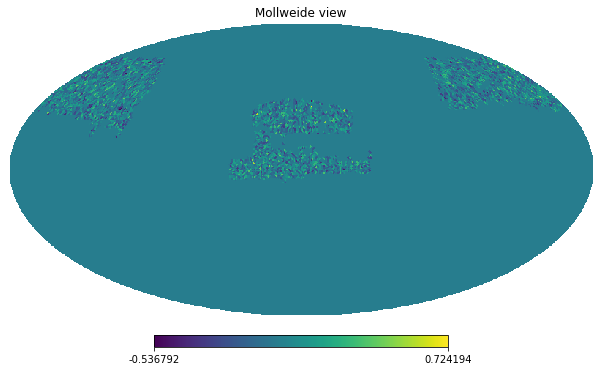

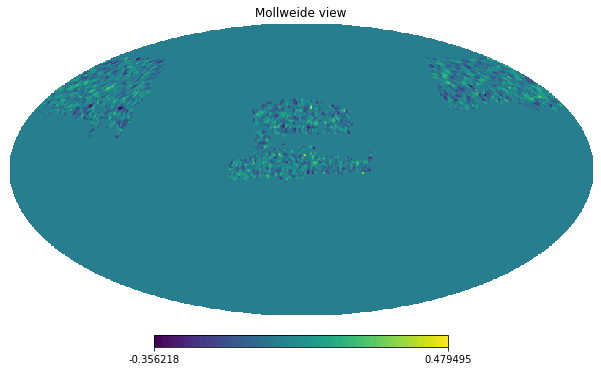

In [9]:
mask_qsos = mask_qsos1 + mask_qsos2
delta_qsos = delta_qsos1 + delta_qsos2
delta_qsos_smooth = delta_qsos1_smooth + delta_qsos2_smooth

hp.mollview(mask_qsos)
hp.mollview(delta_qsos)
hp.mollview(delta_qsos_smooth)

In [10]:
def generate_delta_file(delta, mask, zmid, nz, prefix=None):
    # Compute and fit Cl
    mask_b = np.ones_like(mask)
    mask_b[mask == 0] = 0
    cl = hp.anafast(delta)/np.mean(mask_b)
    ls = np.arange(3*nside)
    par = np.polyfit(ls[3:], np.log(cl[3:]), 6, w=ls[3:]**0.3)
    clfit = np.exp(np.poly1d(par)(ls))
    plt.figure()
    plt.plot(ls, cl, 'k-')
    plt.plot(ls, clfit, 'r-')
    plt.yscale('log')

    # Save
    if prefix is not None:
        hp.write_map(f'data/delta_{prefix}.fits.gz', delta, overwrite=True)
        np.savez(f'data/cl_{prefix}.npz', ls=ls, cl=clfit, cl_data=cl)
        np.savez(f'data/nz_{prefix}.npz', z=zmid, nz=nz, nz_weighted=nz)
    else:
        return delta

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


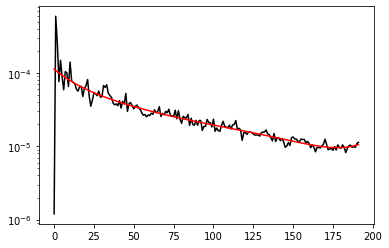

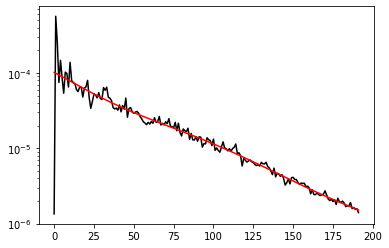

In [11]:
generate_delta_file(delta_cmass, mask_cmass, zcmass, nzcmass,
                    prefix='CMASS_smooth0p0_not_weighted')
generate_delta_file(delta_cmass_smooth, mask_cmass, zcmass, nzcmass,
                    prefix='CMASS_smooth1p0_not_weighted')

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


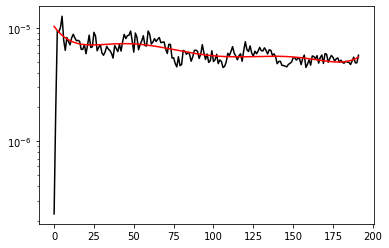

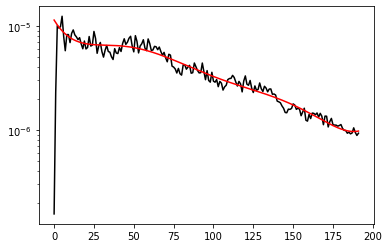

In [12]:
generate_delta_file(delta_qsos, mask_qsos, zqsos, nzqsos,
                    prefix='QSOs_smooth0p0_not_weighted')
generate_delta_file(delta_qsos_smooth, mask_qsos, zqsos, nzqsos,
                    prefix='QSOs_smooth1p0_not_weighted')

# Downgrading to a common resolution and computing covariance

In [13]:
from scipy.special import legendre

def downgrade_covar(prefix, mask, nside_lo=8, mask_thr=0.7):
    # Read and rotate to galactic coords
    r = hp.Rotator(coord=['C', 'G'])
    delta_hi = r.rotate_map_alms(hp.read_map(f'data/delta_{prefix}.fits.gz'))
    mask_r = r.rotate_map_pixel(mask)
    cld = np.load(f'data/cl_{prefix}.npz')
    ls = cld['ls']
    cl = cld['cl_data']
    mask_hi = np.ones_like(mask_r)
    mask_hi[mask_r <= 0] = 0

    # Downgrade
    delta_lo = hp.ud_grade(delta_hi, nside_out=nside_lo)
    mask_lo = hp.ud_grade(mask_hi, nside_out=nside_lo)
    # Correct for area fraction in average
    pix_good = mask_lo > mask_thr
    delta_lo[pix_good] = delta_lo[pix_good]/mask_lo[pix_good]
    delta_lo[~pix_good] = 0
    mask_lo[pix_good] = 1
    mask_lo[~pix_good] = 0
    hp.mollview(delta_hi)
    hp.mollview(delta_lo)
    hp.mollview(mask_hi)
    hp.mollview(mask_lo)

    # Compute signal covariance
    npix_lo = delta_lo.size
    scov = np.zeros([npix_lo, npix_lo])
    u = np.array(hp.pix2vec(nside_lo, np.arange(npix_lo)))
    mu_ij = np.dot(u.T, u)
    for l in range(4*nside_lo):
        scov += cl[l]*(2*l+1)*legendre(l)(mu_ij)/(4*np.pi)
    # Let's calculate the standard deviation
    # and remove a bit to put as part of the noise
    sigma2 = np.mean(np.diag(scov))
    sig2n = 0.1*sigma2
    scov = scov - sig2n*np.eye(npix_lo)
    # Invert it
    sinv = np.linalg.inv(scov)

    # Compute inverse noise covariance
    ninv_diag = np.zeros(npix_lo)
    ninv_diag[pix_good] = 1./sig2n
    ninv = np.diag(ninv_diag)

    # Now compute inverse covariance:
    # C = (S+N) => C^-1 = N^-1 (N^-1+S^-1)^-1 S^-1
    sinv_ninv_inv = np.linalg.inv(ninv+sinv)
    cinv = np.dot(ninv, np.dot(sinv_ninv_inv, sinv))
    plt.figure(figsize=(10, 10))
    plt.imshow(sinv)
    plt.colorbar()
    plt.figure(figsize=(10, 10))
    plt.imshow(cinv)
    plt.colorbar()

    # Test second method
    ndiag = np.zeros(npix_lo)
    ndiag[~pix_good] = 1E200
    cov = scov + np.diag(ndiag)
    cinv2 = np.linalg.inv(cov)
    plt.figure(figsize=(10, 10))
    plt.imshow(cinv2)
    plt.colorbar()

    # Check eigenvalues
    w1, _ = np.linalg.eigh(sinv)
    w2, _ = np.linalg.eigh(cinv)
    w3, _ = np.linalg.eigh(cinv2)
    plt.figure()
    plt.plot(w1, 'r-')
    plt.plot(w2, 'b-')
    plt.plot(w3, 'y--')
    plt.yscale('log')

    # Save
    # Symmetrize first
    cinv = 0.5*(cinv+cinv.T)
    np.savez(f'data/map_cov_{prefix}.npz', map=delta_lo, inv_cov=cinv)

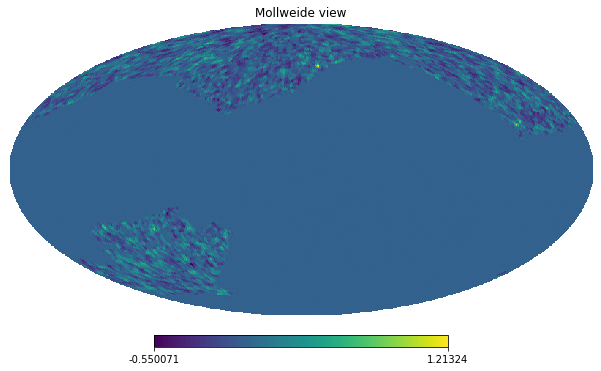

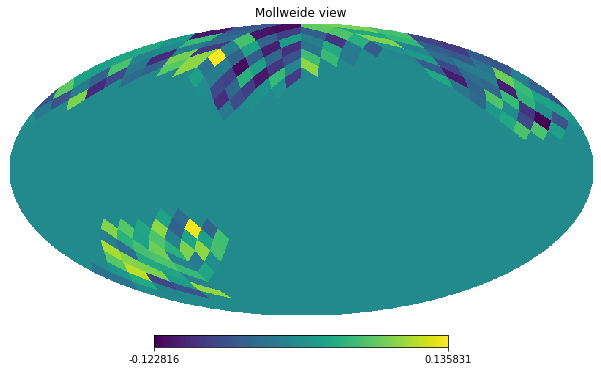

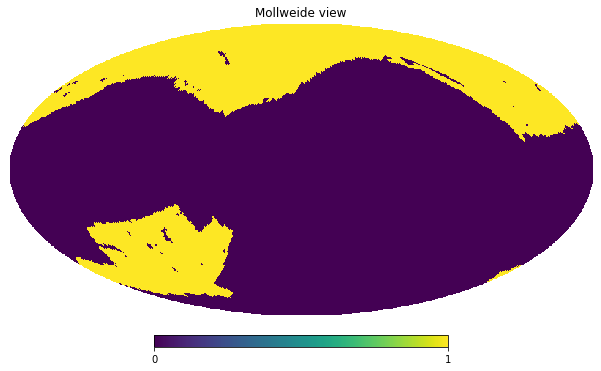

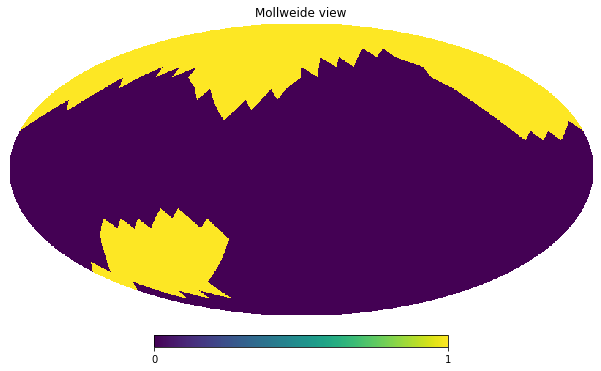

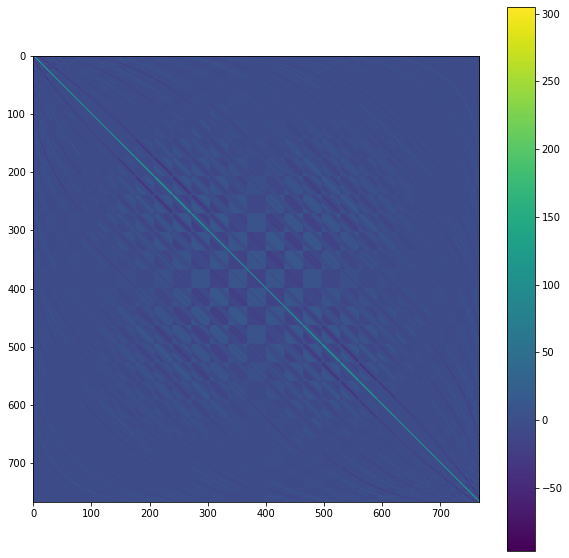

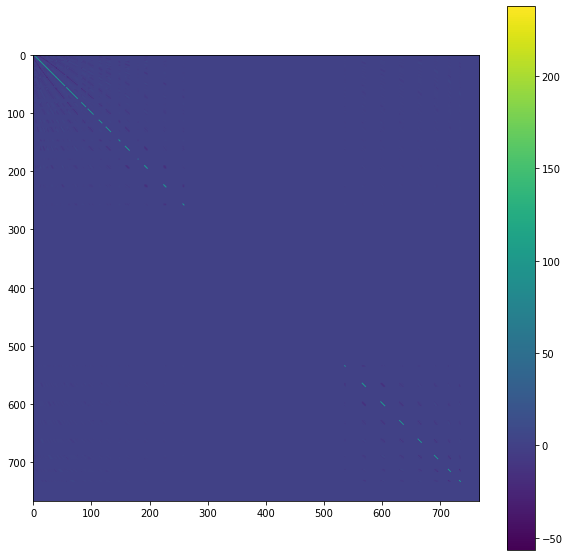

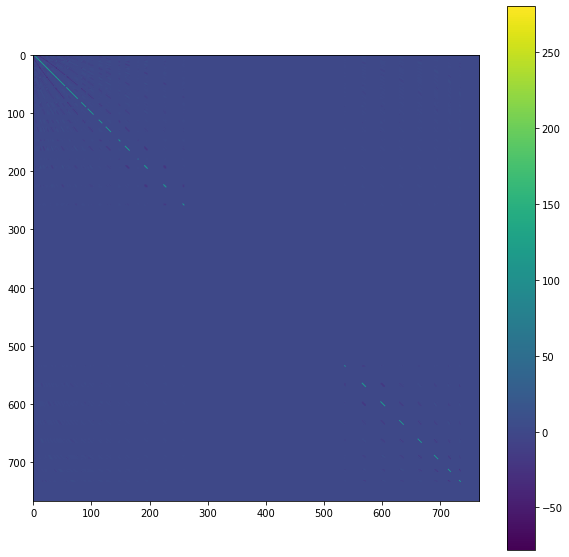

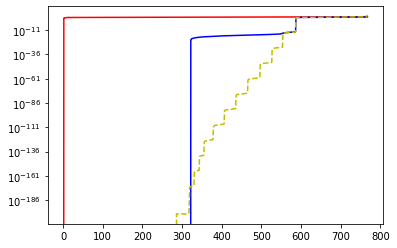

In [14]:
downgrade_covar('CMASS_smooth1p0_not_weighted', mask_cmass)

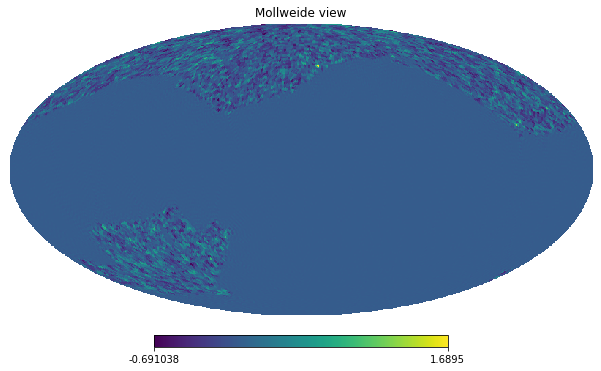

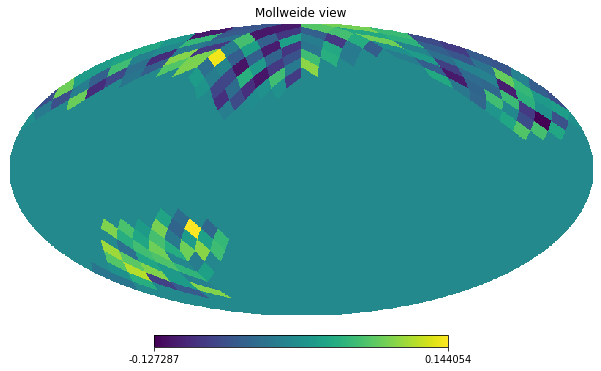

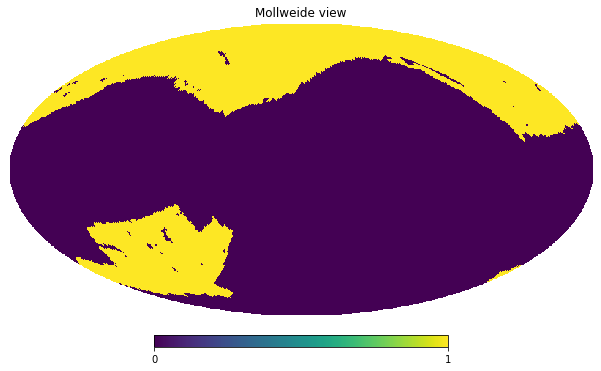

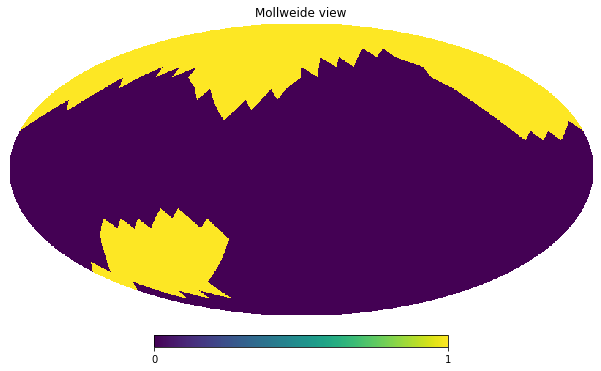

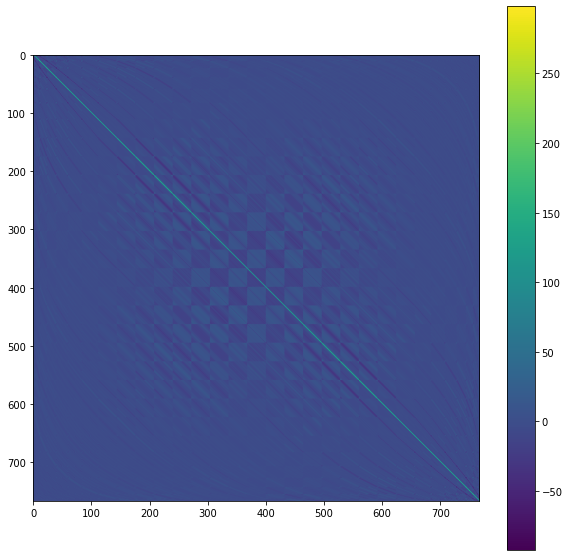

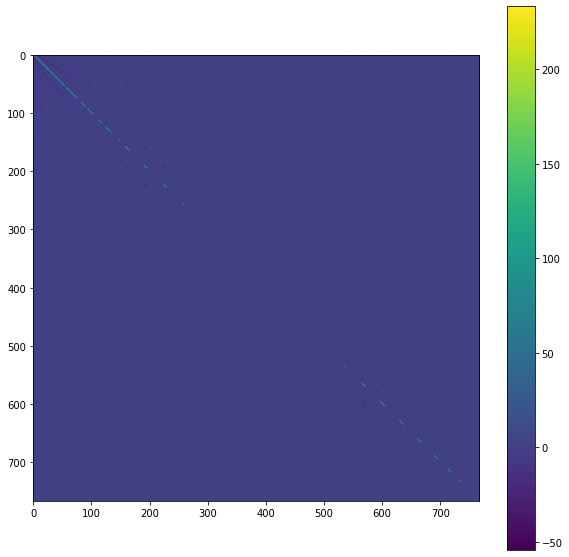

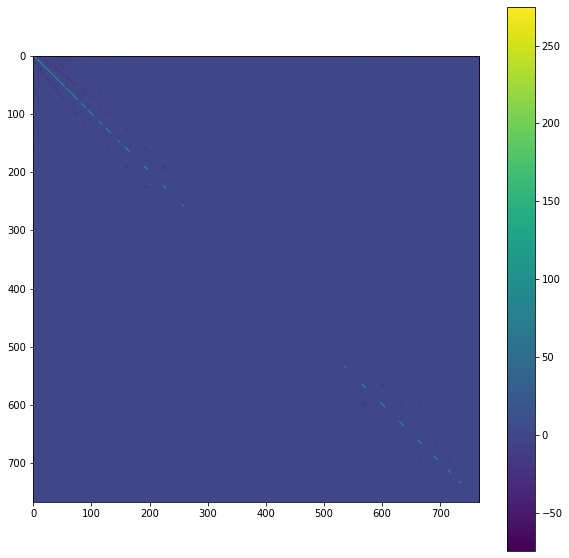

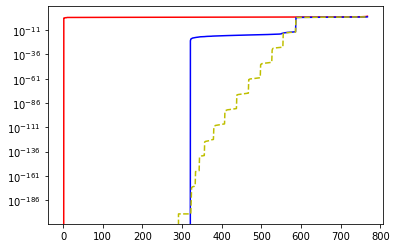

In [15]:
downgrade_covar('CMASS_smooth0p0_not_weighted', mask_cmass)

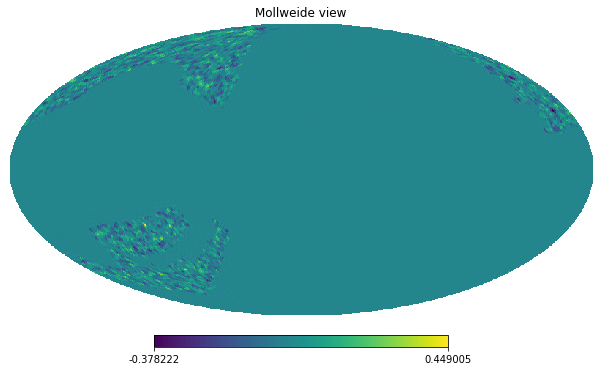

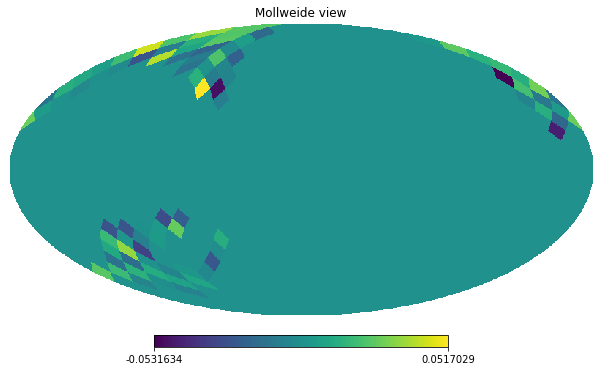

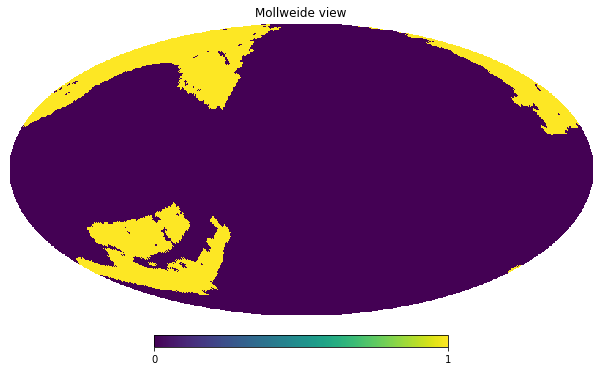

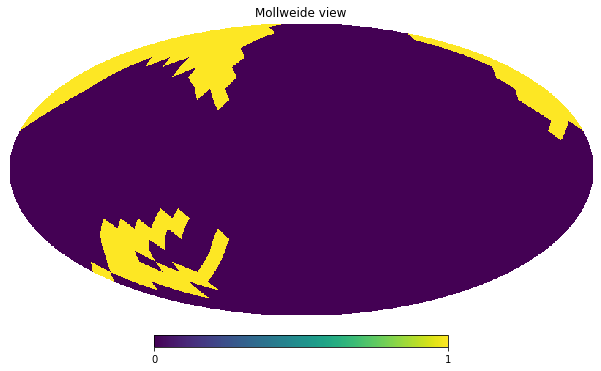

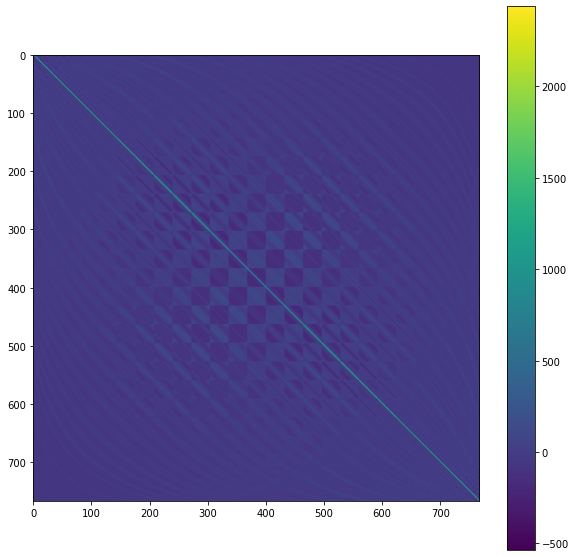

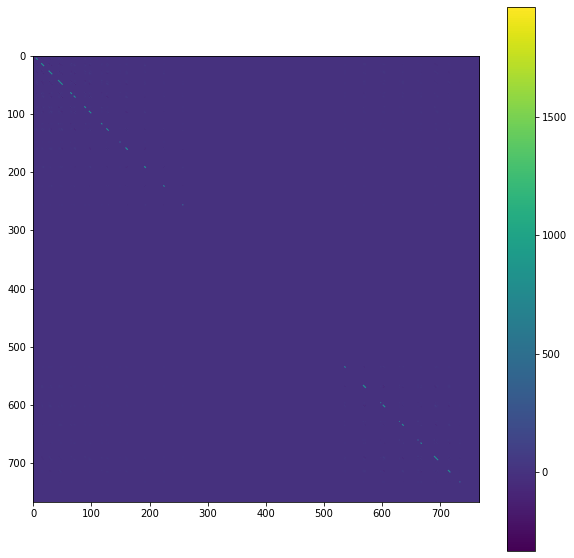

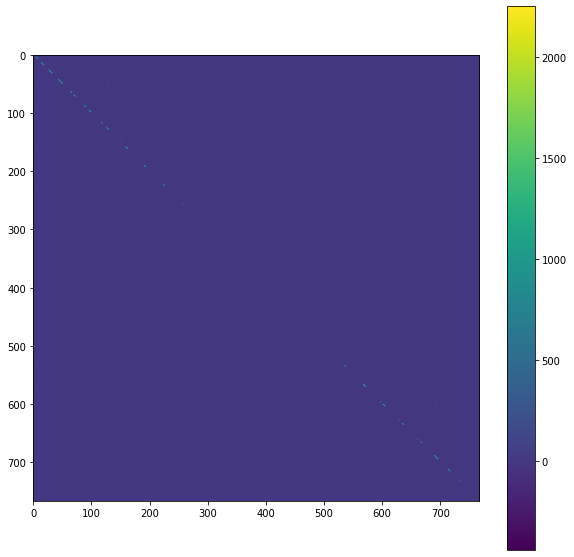

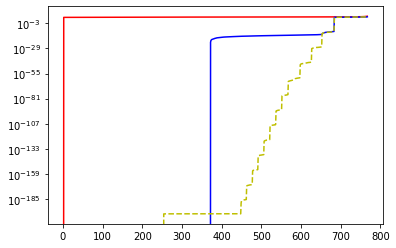

In [16]:
downgrade_covar('QSOs_smooth1p0_not_weighted', mask_qsos)

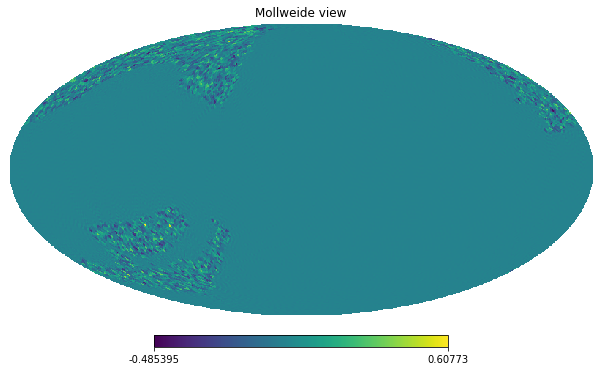

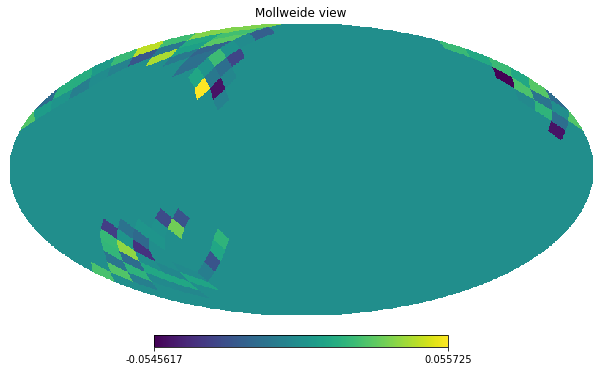

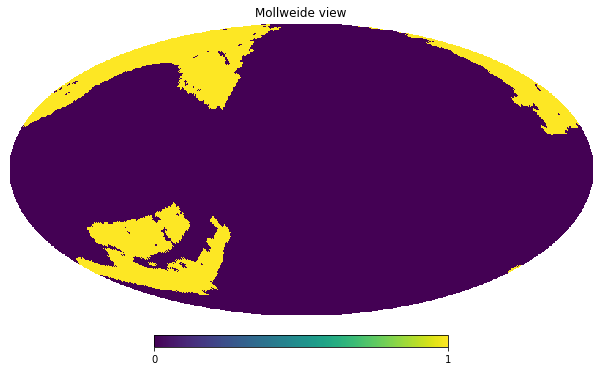

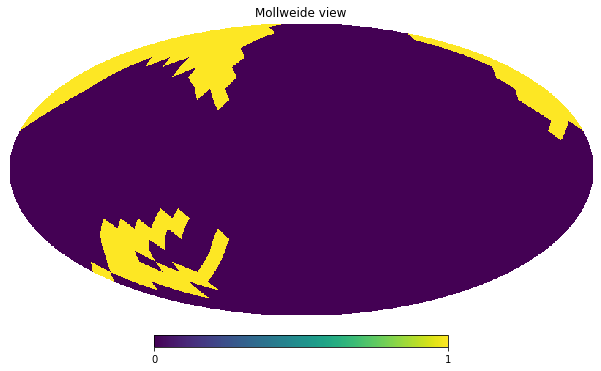

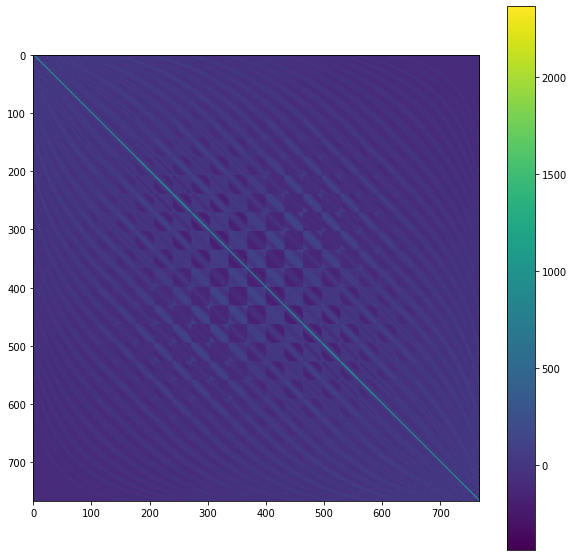

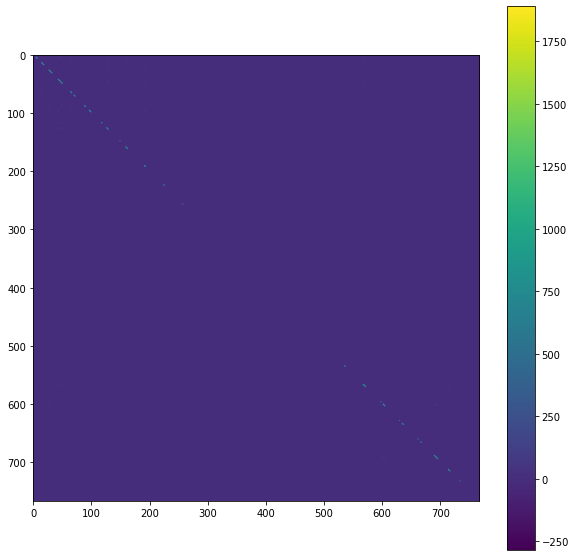

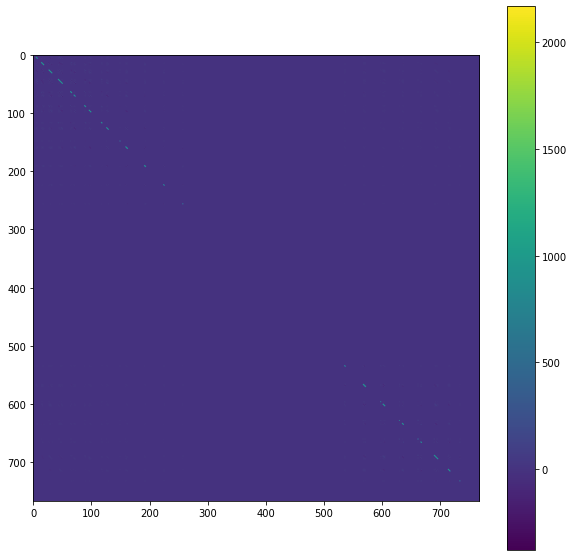

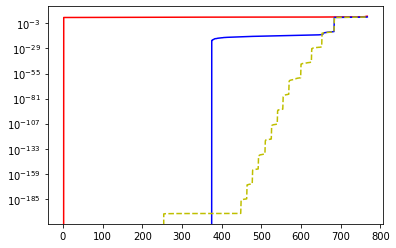

In [17]:
downgrade_covar('QSOs_smooth0p0_not_weighted', mask_qsos)